# 第9章: RNN, CNN

## 80. ID番号への変換
***
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に$1$，2番目に頻出する単語に$2$，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて$0$とせよ．

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2020-06-17 12:28:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  12.7MB/s    in 2.2s    

2020-06-17 12:28:04 (12.7 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!wc -l ./newsCorpora.csv

422937 ./newsCorpora.csv


In [ ]:
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [ ]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 9405

---頻度上位20語---
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


In [ ]:
import torch

def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [ ]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


## 81. RNNによる予測
***
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．

$
\overrightarrow h_0 = 0, \\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$

ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [ ]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden

In [ ]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [ ]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.3273, 0.2282, 0.2454, 0.1992]], grad_fn=<SoftmaxBackward>)
tensor([[0.1324, 0.4295, 0.2220, 0.2162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4091, 0.2159, 0.1736, 0.2014]], grad_fn=<SoftmaxBackward>)
tensor([[0.2081, 0.3668, 0.2390, 0.1861]], grad_fn=<SoftmaxBackward>)
tensor([[0.2383, 0.3205, 0.2695, 0.1717]], grad_fn=<SoftmaxBackward>)
tensor([[0.3224, 0.1460, 0.1993, 0.3324]], grad_fn=<SoftmaxBackward>)
tensor([[0.2012, 0.2345, 0.3660, 0.1982]], grad_fn=<SoftmaxBackward>)
tensor([[0.2072, 0.2365, 0.2525, 0.3038]], grad_fn=<SoftmaxBackward>)
tensor([[0.2681, 0.3235, 0.1889, 0.2195]], grad_fn=<SoftmaxBackward>)
tensor([[0.1969, 0.3336, 0.3064, 0.1631]], grad_fn=<SoftmaxBackward>)


## 82. 確率的勾配降下法による学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(dataset), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break
      
    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1079, accuracy_train: 0.5240, loss_valid: 1.1336, accuracy_valid: 0.5052, 87.5733sec
epoch: 2, loss_train: 1.0197, accuracy_train: 0.5853, loss_valid: 1.0804, accuracy_valid: 0.5621, 87.3570sec
epoch: 3, loss_train: 0.8813, accuracy_train: 0.6736, loss_valid: 0.9771, accuracy_valid: 0.6280, 88.5514sec
epoch: 4, loss_train: 0.7444, accuracy_train: 0.7350, loss_valid: 0.8762, accuracy_valid: 0.6849, 90.5669sec
epoch: 5, loss_train: 0.6475, accuracy_train: 0.7686, loss_valid: 0.8006, accuracy_valid: 0.7096, 89.6673sec
epoch: 6, loss_train: 0.5680, accuracy_train: 0.7935, loss_valid: 0.7516, accuracy_valid: 0.7448, 89.8799sec
epoch: 7, loss_train: 0.5171, accuracy_train: 0.8091, loss_valid: 0.7156, accuracy_valid: 0.7507, 89.9183sec
epoch: 8, loss_train: 0.4852, accuracy_train: 0.8208, loss_valid: 0.7048, accuracy_valid: 0.7545, 90.4226sec
epoch: 9, loss_train: 0.4653, accuracy_train: 0.8263, loss_valid: 0.6948, accuracy_valid: 0.7575, 89.7760sec
epoch: 10, loss_tra

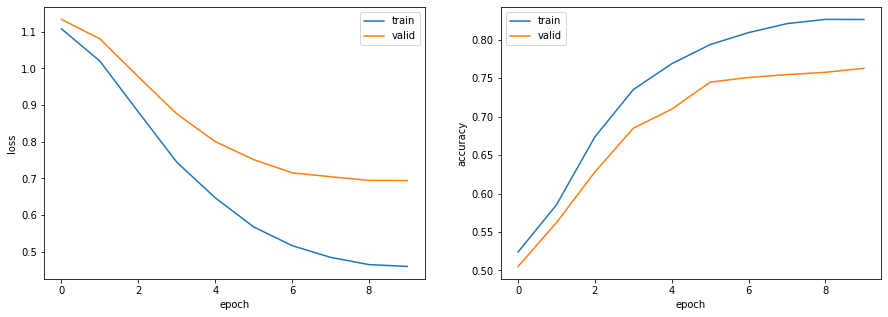

正解率（学習データ）：0.826
正解率（評価データ）：0.775


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 83. ミニバッチ化・GPU上での学習
***
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [ ]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
#device = torch.device('cuda')
device = torch.device('cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2435, accuracy_train: 0.4152, loss_valid: 1.2478, accuracy_valid: 0.4124, 11.4526sec
epoch: 2, loss_train: 1.1968, accuracy_train: 0.4689, loss_valid: 1.2106, accuracy_valid: 0.4491, 11.1898sec
epoch: 3, loss_train: 1.0843, accuracy_train: 0.5854, loss_valid: 1.1033, accuracy_valid: 0.5629, 11.1178sec
epoch: 4, loss_train: 1.0538, accuracy_train: 0.6118, loss_valid: 1.0781, accuracy_valid: 0.5943, 11.2262sec
epoch: 5, loss_train: 1.1818, accuracy_train: 0.5166, loss_valid: 1.2275, accuracy_valid: 0.4933, 11.2383sec
epoch: 6, loss_train: 1.1254, accuracy_train: 0.5518, loss_valid: 1.1650, accuracy_valid: 0.5314, 11.2434sec
epoch: 7, loss_train: 1.0428, accuracy_train: 0.6083, loss_valid: 1.0773, accuracy_valid: 0.5823, 11.1965sec
epoch: 8, loss_train: 1.0125, accuracy_train: 0.6317, loss_valid: 1.0620, accuracy_valid: 0.5906, 11.2190sec
epoch: 9, loss_train: 0.9992, accuracy_train: 0.6397, loss_valid: 1.0440, accuracy_valid: 0.5988, 11.2321sec
epoch: 10, loss_tra

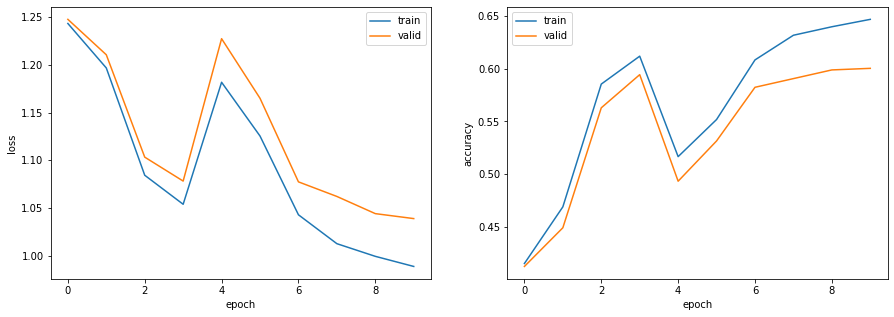

正解率（学習データ）：0.647
正解率（評価データ）：0.618


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 84. 単語ベクトルの導入
***
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．

In [ ]:
# 学習済み単語ベクトルのダウンロード
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2020-06-17 12:45:25--  https://docs.google.com/uc?export=download&confirm=lzAP&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 173.194.79.101, 173.194.79.113, 173.194.79.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-6s-docs.googleusercontent.com/docs/securesc/8bht380iu8t5ninns56qnujgnk9g07h4/56m4oi4drb0mngvkf740631gg93tebrc/1592397900000/06848720943842814915/09660123475506273832Z/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download [following]
--2020-06-17 12:45:26--  https://doc-08-6s-docs.googleusercontent.com/docs/securesc/8bht380iu8t5ninns56qnujgnk9g07h4/56m4oi4drb0mngvkf740631gg93tebrc/1592397900000/06848720943842814915/09660123475506273832Z/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download
Resolving doc-08-6s-docs.googleusercontent.com (doc-08-6s-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to doc-08-6s-

In [ ]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


学習済みベクトル利用単語数: 9174 / 9406
torch.Size([9406, 300])


In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size)
    return hidden

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
#device = torch.device('cuda')
device = torch.device('cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 2, loss_train: 1.1910, accuracy_train: 0.3952, loss_valid: 1.2043, accuracy_valid: 0.3967, 8.5543sec
epoch: 3, loss_train: 1.0754, accuracy_train: 0.5959, loss_valid: 1.1184, accuracy_valid: 0.5749, 8.5370sec
epoch: 4, loss_train: 1.0165, accuracy_train: 0.6400, loss_valid: 1.0331, accuracy_valid: 0.6317, 8.5823sec
epoch: 5, loss_train: 1.0061, accuracy_train: 0.6433, loss_valid: 1.0337, accuracy_valid: 0.6228, 8.5881sec
epoch: 6, loss_train: 0.9627, accuracy_train: 0.6572, loss_valid: 1.0068, accuracy_valid: 0.6407, 8.6434sec
epoch: 7, loss_train: 0.9360, accuracy_train: 0.6659, loss_valid: 0.9661, accuracy_valid: 0.6542, 8.5572sec
epoch: 8, loss_train: 0.9829, accuracy_train: 0.6479, loss_valid: 1.0255, accuracy_valid: 0.6257, 8.5261sec
epoch: 9, loss_train: 0.9470, accuracy_train: 0.6655, loss_valid: 0.9796, accuracy_valid: 0.6452, 8.5703sec
epoch: 10, loss_train: 0.9456, accuracy_train: 0.6662, loss_valid: 0.9828, accuracy_valid: 0.6415, 8.7266sec


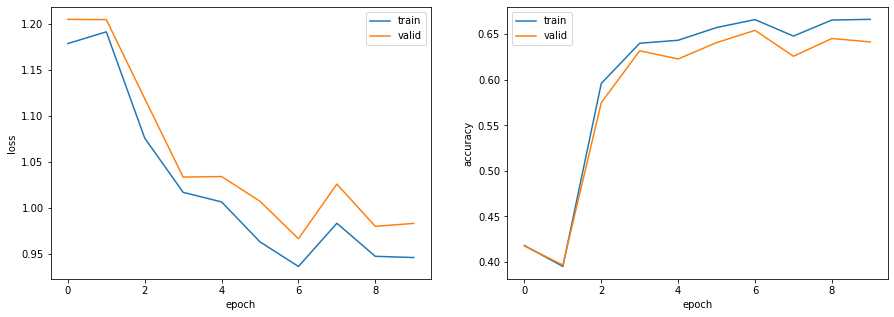

正解率（学習データ）：0.666
正解率（評価データ）：0.647


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 85. 双方向RNN・多層化
***
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
#device = torch.device('cuda')
device = torch.device('cpu')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1651, accuracy_train: 0.4486, loss_valid: 1.1917, accuracy_valid: 0.4229, 17.6173sec
epoch: 2, loss_train: 1.1998, accuracy_train: 0.5170, loss_valid: 1.2576, accuracy_valid: 0.4820, 17.7801sec
epoch: 3, loss_train: 1.1086, accuracy_train: 0.5525, loss_valid: 1.1294, accuracy_valid: 0.5382, 17.6062sec
epoch: 4, loss_train: 1.0089, accuracy_train: 0.6261, loss_valid: 1.0434, accuracy_valid: 0.6040, 17.5407sec
epoch: 5, loss_train: 1.0226, accuracy_train: 0.6152, loss_valid: 1.0740, accuracy_valid: 0.5906, 17.6259sec
epoch: 6, loss_train: 1.0825, accuracy_train: 0.5814, loss_valid: 1.1360, accuracy_valid: 0.5606, 17.5755sec
epoch: 7, loss_train: 1.0577, accuracy_train: 0.5943, loss_valid: 1.1187, accuracy_valid: 0.5681, 17.6940sec
epoch: 8, loss_train: 1.0269, accuracy_train: 0.6138, loss_valid: 1.0800, accuracy_valid: 0.5966, 17.5334sec
epoch: 9, loss_train: 0.9467, accuracy_train: 0.6473, loss_valid: 0.9826, accuracy_valid: 0.6317, 17.5394sec
epoch: 10, loss_tra

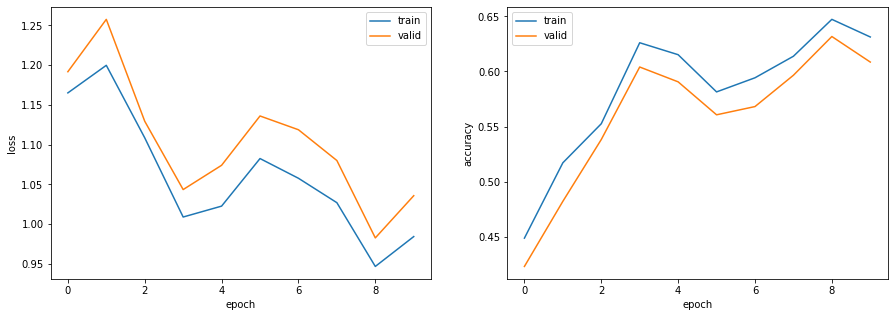

正解率（学習データ）：0.631
正解率（評価データ）：0.613


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 86. 畳み込みニューラルネットワーク (CNN)
***
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$]

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$

 最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

In [ ]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2147, 0.2028, 0.3156, 0.2669]], grad_fn=<SoftmaxBackward>)
tensor([[0.2341, 0.2047, 0.2999, 0.2612]], grad_fn=<SoftmaxBackward>)
tensor([[0.2225, 0.2443, 0.2795, 0.2538]], grad_fn=<SoftmaxBackward>)
tensor([[0.2110, 0.2021, 0.3058, 0.2811]], grad_fn=<SoftmaxBackward>)
tensor([[0.2178, 0.2192, 0.2740, 0.2890]], grad_fn=<SoftmaxBackward>)
tensor([[0.2105, 0.1714, 0.3283, 0.2899]], grad_fn=<SoftmaxBackward>)
tensor([[0.2456, 0.2161, 0.2943, 0.2440]], grad_fn=<SoftmaxBackward>)
tensor([[0.2146, 0.1642, 0.3159, 0.3053]], grad_fn=<SoftmaxBackward>)
tensor([[0.2119, 0.2169, 0.3154, 0.2557]], grad_fn=<SoftmaxBackward>)
tensor([[0.2306, 0.2179, 0.2853, 0.2662]], grad_fn=<SoftmaxBackward>)


## 87. 確率的勾配降下法によるCNNの学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0698, accuracy_train: 0.5664, loss_valid: 1.0806, accuracy_valid: 0.5689, 8.1853sec
epoch: 2, loss_train: 0.9931, accuracy_train: 0.6257, loss_valid: 1.0172, accuracy_valid: 0.6272, 8.0765sec
epoch: 3, loss_train: 0.9157, accuracy_train: 0.6891, loss_valid: 0.9533, accuracy_valid: 0.6714, 8.2263sec
epoch: 4, loss_train: 0.8520, accuracy_train: 0.7122, loss_valid: 0.9003, accuracy_valid: 0.6946, 8.2178sec
epoch: 5, loss_train: 0.8065, accuracy_train: 0.7281, loss_valid: 0.8660, accuracy_valid: 0.7058, 8.1263sec
epoch: 6, loss_train: 0.7739, accuracy_train: 0.7360, loss_valid: 0.8440, accuracy_valid: 0.7133, 8.1508sec
epoch: 7, loss_train: 0.7530, accuracy_train: 0.7416, loss_valid: 0.8284, accuracy_valid: 0.7171, 8.1629sec
epoch: 8, loss_train: 0.7416, accuracy_train: 0.7434, loss_valid: 0.8198, accuracy_valid: 0.7201, 8.1014sec
epoch: 9, loss_train: 0.7352, accuracy_train: 0.7470, loss_valid: 0.8160, accuracy_valid: 0.7223, 8.1012sec
epoch: 10, loss_train: 0.733

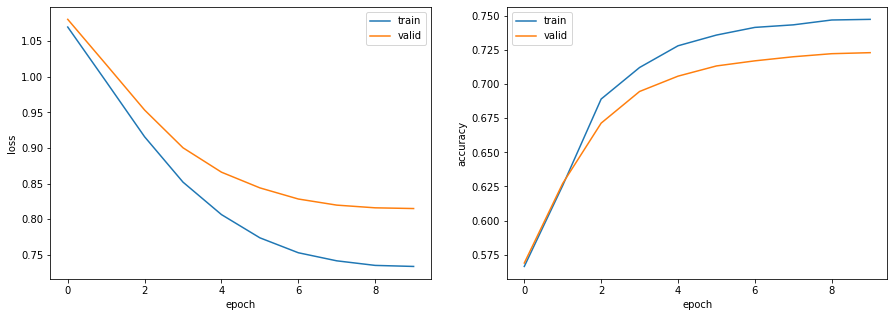

正解率（学習データ）：0.747
正解率（評価データ）：0.716


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 88. パラメータチューニング
***
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [ ]:
!pip install optuna

     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 17.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 112kB 30.0MB/s 
     |████████████████████████████████| 122kB 26.9MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=8aa8f1616f7bce3e291ba505f874e0a156c798e6e8f50363ee2b147912310a2b
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.5.0-cp36-none-any.whl size=276145 sha256=8cedf7830b4ccd519102becf4480f98b1536be2f3f80f840bc3a19c6bc565a3a
  Stored in directory: /root/.cache/pip/wheels/3

In [ ]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [ ]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

  return loss_valid 

In [ ]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=7200)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

epoch: 1, loss_train: 1.1360, accuracy_train: 0.5121, loss_valid: 1.1386, accuracy_valid: 0.5105, 12.9954sec
epoch: 2, loss_train: 1.1012, accuracy_train: 0.5458, loss_valid: 1.1129, accuracy_valid: 0.5202, 12.8651sec
epoch: 3, loss_train: 1.0743, accuracy_train: 0.5665, loss_valid: 1.0901, accuracy_valid: 0.5636, 12.8408sec
epoch: 4, loss_train: 1.0517, accuracy_train: 0.5706, loss_valid: 1.0701, accuracy_valid: 0.5771, 12.8588sec
epoch: 5, loss_train: 1.0300, accuracy_train: 0.5942, loss_valid: 1.0537, accuracy_valid: 0.5891, 12.8499sec
epoch: 6, loss_train: 1.0108, accuracy_train: 0.5884, loss_valid: 1.0373, accuracy_valid: 0.6003, 12.8318sec
epoch: 7, loss_train: 0.9875, accuracy_train: 0.6403, loss_valid: 1.0206, accuracy_valid: 0.6272, 12.8480sec
epoch: 8, loss_train: 0.9676, accuracy_train: 0.6487, loss_valid: 1.0031, accuracy_valid: 0.6475, 12.8275sec
epoch: 9, loss_train: 0.9462, accuracy_train: 0.6690, loss_valid: 0.9871, accuracy_valid: 0.6549, 12.8349sec
epoch: 10, loss_tra

[I 2020-06-17 13:02:19,461] Finished trial#0 with value: 0.8635633598544641 with parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.2, 'learning_rate': 0.00958038099655327, 'momentum': 0.5, 'batch_size': 96.0}. Best is trial#0 with value: 0.8635633598544641.


epoch: 1, loss_train: 1.1583, accuracy_train: 0.5076, loss_valid: 1.1582, accuracy_valid: 0.4775, 13.2802sec
epoch: 2, loss_train: 1.1385, accuracy_train: 0.5192, loss_valid: 1.1417, accuracy_valid: 0.4858, 13.2768sec
epoch: 3, loss_train: 1.1212, accuracy_train: 0.5364, loss_valid: 1.1258, accuracy_valid: 0.5165, 13.2340sec
epoch: 4, loss_train: 1.1059, accuracy_train: 0.5476, loss_valid: 1.1130, accuracy_valid: 0.5322, 13.2471sec
epoch: 5, loss_train: 1.0930, accuracy_train: 0.5462, loss_valid: 1.1040, accuracy_valid: 0.5172, 13.3136sec
epoch: 6, loss_train: 1.0800, accuracy_train: 0.5544, loss_valid: 1.0897, accuracy_valid: 0.5621, 13.2478sec
epoch: 7, loss_train: 1.0680, accuracy_train: 0.5646, loss_valid: 1.0811, accuracy_valid: 0.5696, 13.2638sec
epoch: 8, loss_train: 1.0573, accuracy_train: 0.5810, loss_valid: 1.0745, accuracy_valid: 0.5808, 13.2538sec
epoch: 9, loss_train: 1.0481, accuracy_train: 0.5697, loss_valid: 1.0652, accuracy_valid: 0.5816, 13.2676sec
epoch: 10, loss_tra

[I 2020-06-17 13:08:58,900] Finished trial#1 with value: 0.9960923864545222 with parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.1, 'learning_rate': 0.0009487445797962559, 'momentum': 0.7, 'batch_size': 32.0}. Best is trial#0 with value: 0.8635633598544641.


epoch: 1, loss_train: 1.0485, accuracy_train: 0.5951, loss_valid: 1.0673, accuracy_valid: 0.5898, 12.0611sec
epoch: 2, loss_train: 0.9502, accuracy_train: 0.6703, loss_valid: 0.9883, accuracy_valid: 0.6557, 12.1441sec
epoch: 3, loss_train: 0.8541, accuracy_train: 0.7100, loss_valid: 0.9055, accuracy_valid: 0.6969, 12.0783sec
epoch: 4, loss_train: 0.7749, accuracy_train: 0.7362, loss_valid: 0.8498, accuracy_valid: 0.7133, 12.0802sec
epoch: 5, loss_train: 0.7086, accuracy_train: 0.7558, loss_valid: 0.8038, accuracy_valid: 0.7268, 12.0763sec
epoch: 6, loss_train: 0.6501, accuracy_train: 0.7713, loss_valid: 0.7678, accuracy_valid: 0.7305, 12.0236sec
epoch: 7, loss_train: 0.5968, accuracy_train: 0.7866, loss_valid: 0.7366, accuracy_valid: 0.7388, 12.0347sec
epoch: 8, loss_train: 0.5464, accuracy_train: 0.8043, loss_valid: 0.7027, accuracy_valid: 0.7478, 12.0472sec
epoch: 9, loss_train: 0.5003, accuracy_train: 0.8328, loss_valid: 0.6808, accuracy_valid: 0.7560, 11.9774sec
epoch: 10, loss_tra

[I 2020-06-17 13:15:02,116] Finished trial#2 with value: 0.5368596914999499 with parameters: {'emb_size': 400.0, 'out_channels': 100.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.016841174733157577, 'momentum': 0.7, 'batch_size': 64.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.1065, accuracy_train: 0.5317, loss_valid: 1.1173, accuracy_valid: 0.5105, 14.8082sec
epoch: 2, loss_train: 1.0595, accuracy_train: 0.5854, loss_valid: 1.0759, accuracy_valid: 0.5711, 14.7348sec
epoch: 3, loss_train: 1.0179, accuracy_train: 0.6137, loss_valid: 1.0443, accuracy_valid: 0.6100, 14.8035sec
epoch: 4, loss_train: 0.9769, accuracy_train: 0.6364, loss_valid: 1.0074, accuracy_valid: 0.6310, 14.7558sec
epoch: 5, loss_train: 0.9374, accuracy_train: 0.6869, loss_valid: 0.9789, accuracy_valid: 0.6587, 14.8041sec
epoch: 6, loss_train: 0.8952, accuracy_train: 0.7002, loss_valid: 0.9422, accuracy_valid: 0.6849, 14.7877sec
epoch: 7, loss_train: 0.8585, accuracy_train: 0.7155, loss_valid: 0.9139, accuracy_valid: 0.6946, 14.7260sec
epoch: 8, loss_train: 0.8246, accuracy_train: 0.7225, loss_valid: 0.8876, accuracy_valid: 0.7036, 14.7761sec
epoch: 9, loss_train: 0.7955, accuracy_train: 0.7311, loss_valid: 0.8658, accuracy_valid: 0.7073, 14.7773sec
epoch: 10, loss_tra

[I 2020-06-17 13:22:26,977] Finished trial#3 with value: 0.7349026674282051 with parameters: {'emb_size': 400.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.0018545140222758923, 'momentum': 0.7, 'batch_size': 16.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.0636, accuracy_train: 0.5883, loss_valid: 1.0801, accuracy_valid: 0.5808, 11.9527sec
epoch: 2, loss_train: 0.9764, accuracy_train: 0.6342, loss_valid: 1.0059, accuracy_valid: 0.6370, 11.9888sec
epoch: 3, loss_train: 0.8860, accuracy_train: 0.7034, loss_valid: 0.9335, accuracy_valid: 0.6856, 11.9816sec
epoch: 4, loss_train: 0.8080, accuracy_train: 0.7233, loss_valid: 0.8733, accuracy_valid: 0.7006, 11.9767sec
epoch: 5, loss_train: 0.7442, accuracy_train: 0.7437, loss_valid: 0.8264, accuracy_valid: 0.7201, 11.9062sec
epoch: 6, loss_train: 0.6883, accuracy_train: 0.7598, loss_valid: 0.7906, accuracy_valid: 0.7208, 11.8765sec
epoch: 7, loss_train: 0.6404, accuracy_train: 0.7737, loss_valid: 0.7645, accuracy_valid: 0.7350, 11.9412sec
epoch: 8, loss_train: 0.5932, accuracy_train: 0.7928, loss_valid: 0.7360, accuracy_valid: 0.7433, 11.9607sec
epoch: 9, loss_train: 0.5517, accuracy_train: 0.8077, loss_valid: 0.7067, accuracy_valid: 0.7493, 11.9854sec
epoch: 10, loss_tra

[I 2020-06-17 13:28:27,476] Finished trial#4 with value: 0.5511604079943218 with parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.006849437963164003, 'momentum': 0.9, 'batch_size': 80.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.1423, accuracy_train: 0.5171, loss_valid: 1.1439, accuracy_valid: 0.5120, 12.9064sec
epoch: 2, loss_train: 1.1137, accuracy_train: 0.5405, loss_valid: 1.1203, accuracy_valid: 0.5217, 12.9228sec
epoch: 3, loss_train: 1.0920, accuracy_train: 0.5409, loss_valid: 1.0993, accuracy_valid: 0.5509, 12.8745sec
epoch: 4, loss_train: 1.0714, accuracy_train: 0.5706, loss_valid: 1.0863, accuracy_valid: 0.5734, 12.8700sec
epoch: 5, loss_train: 1.0538, accuracy_train: 0.5860, loss_valid: 1.0737, accuracy_valid: 0.5853, 12.8836sec
epoch: 6, loss_train: 1.0368, accuracy_train: 0.5939, loss_valid: 1.0593, accuracy_valid: 0.5951, 12.9005sec
epoch: 7, loss_train: 1.0203, accuracy_train: 0.6112, loss_valid: 1.0455, accuracy_valid: 0.6070, 12.8965sec
epoch: 8, loss_train: 1.0045, accuracy_train: 0.6279, loss_valid: 1.0317, accuracy_valid: 0.6168, 12.9723sec
epoch: 9, loss_train: 0.9894, accuracy_train: 0.6282, loss_valid: 1.0197, accuracy_valid: 0.6175, 12.8981sec
epoch: 10, loss_tra

[I 2020-06-17 13:34:56,305] Finished trial#5 with value: 0.9138848686111187 with parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.5, 'learning_rate': 0.0021067584334446957, 'momentum': 0.8, 'batch_size': 64.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.1867, accuracy_train: 0.4861, loss_valid: 1.1819, accuracy_valid: 0.4641, 12.0411sec
epoch: 2, loss_train: 1.1564, accuracy_train: 0.5110, loss_valid: 1.1566, accuracy_valid: 0.4850, 12.0857sec
epoch: 3, loss_train: 1.1392, accuracy_train: 0.5268, loss_valid: 1.1416, accuracy_valid: 0.5112, 11.9644sec
epoch: 4, loss_train: 1.1250, accuracy_train: 0.5354, loss_valid: 1.1293, accuracy_valid: 0.5195, 11.9909sec
epoch: 5, loss_train: 1.1129, accuracy_train: 0.5388, loss_valid: 1.1186, accuracy_valid: 0.5292, 12.0159sec
epoch: 6, loss_train: 1.1024, accuracy_train: 0.5416, loss_valid: 1.1093, accuracy_valid: 0.5442, 11.9294sec
epoch: 7, loss_train: 1.0929, accuracy_train: 0.5483, loss_valid: 1.1016, accuracy_valid: 0.5516, 12.0023sec
epoch: 8, loss_train: 1.0845, accuracy_train: 0.5584, loss_valid: 1.0953, accuracy_valid: 0.5636, 12.0043sec
epoch: 9, loss_train: 1.0769, accuracy_train: 0.5577, loss_valid: 1.0887, accuracy_valid: 0.5659, 11.9600sec
epoch: 10, loss_tra

[I 2020-06-17 13:40:57,115] Finished trial#6 with value: 1.0392130491976252 with parameters: {'emb_size': 300.0, 'out_channels': 50.0, 'drop_rate': 0.4, 'learning_rate': 0.0027450605405002423, 'momentum': 0.6, 'batch_size': 80.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.1499, accuracy_train: 0.5194, loss_valid: 1.1505, accuracy_valid: 0.5030, 14.7042sec
epoch: 2, loss_train: 1.1232, accuracy_train: 0.5397, loss_valid: 1.1265, accuracy_valid: 0.5180, 14.7119sec
epoch: 3, loss_train: 1.0999, accuracy_train: 0.5501, loss_valid: 1.1072, accuracy_valid: 0.5322, 14.7540sec
epoch: 4, loss_train: 1.0801, accuracy_train: 0.5609, loss_valid: 1.0931, accuracy_valid: 0.5389, 14.7366sec
epoch: 5, loss_train: 1.0624, accuracy_train: 0.5773, loss_valid: 1.0775, accuracy_valid: 0.5644, 14.7069sec
epoch: 6, loss_train: 1.0461, accuracy_train: 0.5907, loss_valid: 1.0634, accuracy_valid: 0.5808, 14.7753sec
epoch: 7, loss_train: 1.0309, accuracy_train: 0.5908, loss_valid: 1.0513, accuracy_valid: 0.6003, 14.7042sec
epoch: 8, loss_train: 1.0172, accuracy_train: 0.5870, loss_valid: 1.0378, accuracy_valid: 0.5921, 14.7821sec
epoch: 9, loss_train: 1.0010, accuracy_train: 0.6258, loss_valid: 1.0285, accuracy_valid: 0.6265, 14.7648sec
epoch: 10, loss_tra

[I 2020-06-17 13:48:20,163] Finished trial#7 with value: 0.9201359981726743 with parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.0, 'learning_rate': 0.0009391050690086679, 'momentum': 0.6, 'batch_size': 16.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.2404, accuracy_train: 0.4040, loss_valid: 1.2341, accuracy_valid: 0.4049, 11.9181sec
epoch: 2, loss_train: 1.1999, accuracy_train: 0.4401, loss_valid: 1.1946, accuracy_valid: 0.4356, 11.8263sec
epoch: 3, loss_train: 1.1829, accuracy_train: 0.4871, loss_valid: 1.1793, accuracy_valid: 0.4701, 11.7867sec
epoch: 4, loss_train: 1.1736, accuracy_train: 0.5001, loss_valid: 1.1716, accuracy_valid: 0.4865, 11.8512sec
epoch: 5, loss_train: 1.1673, accuracy_train: 0.5011, loss_valid: 1.1666, accuracy_valid: 0.4873, 11.9049sec
epoch: 6, loss_train: 1.1624, accuracy_train: 0.5056, loss_valid: 1.1626, accuracy_valid: 0.4948, 11.8402sec
epoch: 7, loss_train: 1.1583, accuracy_train: 0.5080, loss_valid: 1.1591, accuracy_valid: 0.4948, 11.9240sec
epoch: 8, loss_train: 1.1547, accuracy_train: 0.5099, loss_valid: 1.1561, accuracy_valid: 0.4955, 11.8848sec
epoch: 9, loss_train: 1.1514, accuracy_train: 0.5122, loss_valid: 1.1533, accuracy_valid: 0.4955, 11.9217sec
epoch: 10, loss_tra

[I 2020-06-17 13:54:18,287] Finished trial#8 with value: 1.1328078816661578 with parameters: {'emb_size': 100.0, 'out_channels': 100.0, 'drop_rate': 0.2, 'learning_rate': 0.0007930027695409871, 'momentum': 0.6, 'batch_size': 112.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 1.1626, accuracy_train: 0.5151, loss_valid: 1.1629, accuracy_valid: 0.4798, 14.6963sec
epoch: 2, loss_train: 1.1426, accuracy_train: 0.5302, loss_valid: 1.1448, accuracy_valid: 0.5157, 14.6392sec
epoch: 3, loss_train: 1.1263, accuracy_train: 0.5327, loss_valid: 1.1313, accuracy_valid: 0.5090, 14.7113sec
epoch: 4, loss_train: 1.1119, accuracy_train: 0.5498, loss_valid: 1.1183, accuracy_valid: 0.5337, 14.7177sec
epoch: 5, loss_train: 1.0991, accuracy_train: 0.5584, loss_valid: 1.1077, accuracy_valid: 0.5494, 14.7298sec
epoch: 6, loss_train: 1.0876, accuracy_train: 0.5631, loss_valid: 1.0976, accuracy_valid: 0.5584, 14.7730sec
epoch: 7, loss_train: 1.0773, accuracy_train: 0.5696, loss_valid: 1.0899, accuracy_valid: 0.5644, 14.7082sec
epoch: 8, loss_train: 1.0679, accuracy_train: 0.5763, loss_valid: 1.0822, accuracy_valid: 0.5719, 14.7982sec
epoch: 9, loss_train: 1.0593, accuracy_train: 0.5814, loss_valid: 1.0748, accuracy_valid: 0.5771, 14.7254sec
epoch: 10, loss_tra

[I 2020-06-17 14:01:41,690] Finished trial#9 with value: 1.0154534751872817 with parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.0005931529071117646, 'momentum': 0.6, 'batch_size': 16.0}. Best is trial#2 with value: 0.5368596914999499.


epoch: 1, loss_train: 0.7087, accuracy_train: 0.7480, loss_valid: 0.8040, accuracy_valid: 0.7141, 12.2162sec
epoch: 2, loss_train: 0.4496, accuracy_train: 0.8470, loss_valid: 0.6316, accuracy_valid: 0.7732, 12.1024sec
epoch: 3, loss_train: 0.2892, accuracy_train: 0.9180, loss_valid: 0.5666, accuracy_valid: 0.7979, 12.1048sec
epoch: 4, loss_train: 0.1873, accuracy_train: 0.9484, loss_valid: 0.5334, accuracy_valid: 0.8136, 12.0647sec
epoch: 5, loss_train: 0.1240, accuracy_train: 0.9717, loss_valid: 0.5323, accuracy_valid: 0.8144, 12.1139sec
epoch: 6, loss_train: 0.0831, accuracy_train: 0.9871, loss_valid: 0.5072, accuracy_valid: 0.8234, 12.0742sec
epoch: 7, loss_train: 0.0566, accuracy_train: 0.9933, loss_valid: 0.5225, accuracy_valid: 0.8234, 12.0991sec
epoch: 8, loss_train: 0.0397, accuracy_train: 0.9960, loss_valid: 0.5073, accuracy_valid: 0.8361, 12.1136sec
epoch: 9, loss_train: 0.0323, accuracy_train: 0.9970, loss_valid: 0.5144, accuracy_valid: 0.8398, 12.0670sec
epoch: 10, loss_tra

[I 2020-06-17 14:03:56,195] Finished trial#10 with value: 0.5289085468578482 with parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.034525441505265694, 'momentum': 0.9, 'batch_size': 48.0}. Best is trial#10 with value: 0.5289085468578482.


epoch: 1, loss_train: 0.6658, accuracy_train: 0.7605, loss_valid: 0.7783, accuracy_valid: 0.7275, 11.9764sec
epoch: 2, loss_train: 0.4267, accuracy_train: 0.8696, loss_valid: 0.6325, accuracy_valid: 0.7769, 12.0476sec
epoch: 3, loss_train: 0.2685, accuracy_train: 0.9071, loss_valid: 0.5655, accuracy_valid: 0.7927, 12.1993sec
epoch: 4, loss_train: 0.1571, accuracy_train: 0.9580, loss_valid: 0.5324, accuracy_valid: 0.8136, 12.0665sec
epoch: 5, loss_train: 0.1039, accuracy_train: 0.9788, loss_valid: 0.5338, accuracy_valid: 0.8226, 12.0895sec
epoch: 6, loss_train: 0.0658, accuracy_train: 0.9887, loss_valid: 0.5421, accuracy_valid: 0.8293, 12.0781sec
epoch: 7, loss_train: 0.0476, accuracy_train: 0.9937, loss_valid: 0.5287, accuracy_valid: 0.8278, 12.1191sec
epoch: 8, loss_train: 0.0336, accuracy_train: 0.9956, loss_valid: 0.5546, accuracy_valid: 0.8256, 12.0580sec
epoch: 9, loss_train: 0.0322, accuracy_train: 0.9961, loss_valid: 0.5786, accuracy_valid: 0.8263, 12.0674sec
epoch: 10, loss_tra

[I 2020-06-17 14:09:57,598] Finished trial#11 with value: 0.6185752343453333 with parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.04635897321301914, 'momentum': 0.9, 'batch_size': 48.0}. Best is trial#10 with value: 0.5289085468578482.


epoch: 1, loss_train: 0.8724, accuracy_train: 0.6973, loss_valid: 0.9158, accuracy_valid: 0.6864, 12.0428sec
epoch: 2, loss_train: 0.6797, accuracy_train: 0.7606, loss_valid: 0.7758, accuracy_valid: 0.7365, 12.1062sec
epoch: 3, loss_train: 0.5267, accuracy_train: 0.8248, loss_valid: 0.6943, accuracy_valid: 0.7612, 12.0625sec
epoch: 4, loss_train: 0.4203, accuracy_train: 0.8641, loss_valid: 0.6280, accuracy_valid: 0.7904, 12.0708sec
epoch: 5, loss_train: 0.3026, accuracy_train: 0.9146, loss_valid: 0.5622, accuracy_valid: 0.8069, 12.1008sec
epoch: 6, loss_train: 0.2355, accuracy_train: 0.9389, loss_valid: 0.5314, accuracy_valid: 0.8114, 12.0856sec
epoch: 7, loss_train: 0.1864, accuracy_train: 0.9521, loss_valid: 0.5264, accuracy_valid: 0.8196, 12.1144sec
epoch: 8, loss_train: 0.1454, accuracy_train: 0.9785, loss_valid: 0.5166, accuracy_valid: 0.8241, 12.2034sec
epoch: 9, loss_train: 0.1190, accuracy_train: 0.9751, loss_valid: 0.5077, accuracy_valid: 0.8211, 12.0866sec
epoch: 10, loss_tra

[I 2020-06-17 14:12:48,402] Finished trial#12 with value: 0.4925020979996213 with parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.028464405865370475, 'momentum': 0.8, 'batch_size': 48.0}. Best is trial#12 with value: 0.4925020979996213.


epoch: 1, loss_train: 0.7927, accuracy_train: 0.7214, loss_valid: 0.8594, accuracy_valid: 0.7073, 12.0505sec
epoch: 2, loss_train: 0.5934, accuracy_train: 0.7829, loss_valid: 0.7247, accuracy_valid: 0.7388, 12.1143sec
epoch: 3, loss_train: 0.4181, accuracy_train: 0.8536, loss_valid: 0.6188, accuracy_valid: 0.7762, 11.9806sec
epoch: 4, loss_train: 0.2988, accuracy_train: 0.9020, loss_valid: 0.5590, accuracy_valid: 0.8091, 11.7136sec
epoch: 5, loss_train: 0.2333, accuracy_train: 0.9228, loss_valid: 0.5527, accuracy_valid: 0.7949, 11.7592sec
epoch: 6, loss_train: 0.1579, accuracy_train: 0.9658, loss_valid: 0.5153, accuracy_valid: 0.8121, 11.8042sec
epoch: 7, loss_train: 0.1185, accuracy_train: 0.9778, loss_valid: 0.5146, accuracy_valid: 0.8234, 11.7114sec
epoch: 8, loss_train: 0.0887, accuracy_train: 0.9866, loss_valid: 0.4981, accuracy_valid: 0.8406, 11.7464sec
epoch: 9, loss_train: 0.0645, accuracy_train: 0.9937, loss_valid: 0.5085, accuracy_valid: 0.8204, 11.7004sec
epoch: 10, loss_tra

[I 2020-06-17 14:16:35,521] Finished trial#13 with value: 0.5135139734623675 with parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.03917449364365402, 'momentum': 0.8, 'batch_size': 48.0}. Best is trial#12 with value: 0.4925020979996213.


epoch: 1, loss_train: 0.9259, accuracy_train: 0.6955, loss_valid: 0.9629, accuracy_valid: 0.6707, 12.0458sec
epoch: 2, loss_train: 0.7548, accuracy_train: 0.7288, loss_valid: 0.8341, accuracy_valid: 0.7066, 11.9236sec
epoch: 3, loss_train: 0.6170, accuracy_train: 0.7810, loss_valid: 0.7466, accuracy_valid: 0.7373, 11.9566sec
epoch: 4, loss_train: 0.5030, accuracy_train: 0.8224, loss_valid: 0.6778, accuracy_valid: 0.7597, 11.8268sec
epoch: 5, loss_train: 0.4038, accuracy_train: 0.8627, loss_valid: 0.6131, accuracy_valid: 0.7807, 11.8705sec
epoch: 6, loss_train: 0.3307, accuracy_train: 0.8998, loss_valid: 0.5765, accuracy_valid: 0.8039, 11.8286sec
epoch: 7, loss_train: 0.2766, accuracy_train: 0.9183, loss_valid: 0.5580, accuracy_valid: 0.8001, 11.8968sec
epoch: 8, loss_train: 0.2267, accuracy_train: 0.9466, loss_valid: 0.5389, accuracy_valid: 0.8114, 11.8337sec
epoch: 9, loss_train: 0.1882, accuracy_train: 0.9632, loss_valid: 0.5243, accuracy_valid: 0.8226, 11.8619sec
epoch: 10, loss_tra

[I 2020-06-17 14:22:33,450] Finished trial#14 with value: 0.48151480879433856 with parameters: {'emb_size': 300.0, 'out_channels': 50.0, 'drop_rate': 0.4, 'learning_rate': 0.02309862778484548, 'momentum': 0.8, 'batch_size': 48.0}. Best is trial#14 with value: 0.48151480879433856.


epoch: 1, loss_train: 0.8457, accuracy_train: 0.7127, loss_valid: 0.8929, accuracy_valid: 0.7013, 12.1504sec
epoch: 2, loss_train: 0.6599, accuracy_train: 0.7702, loss_valid: 0.7701, accuracy_valid: 0.7201, 12.1493sec
epoch: 3, loss_train: 0.5174, accuracy_train: 0.8121, loss_valid: 0.6752, accuracy_valid: 0.7552, 12.1756sec
epoch: 4, loss_train: 0.3974, accuracy_train: 0.8668, loss_valid: 0.6012, accuracy_valid: 0.7897, 12.2123sec
epoch: 5, loss_train: 0.3076, accuracy_train: 0.9069, loss_valid: 0.5603, accuracy_valid: 0.8069, 12.1903sec
epoch: 6, loss_train: 0.2509, accuracy_train: 0.9345, loss_valid: 0.5428, accuracy_valid: 0.8091, 12.1596sec
epoch: 7, loss_train: 0.1940, accuracy_train: 0.9458, loss_valid: 0.5154, accuracy_valid: 0.8211, 12.1180sec
epoch: 8, loss_train: 0.1595, accuracy_train: 0.9642, loss_valid: 0.5193, accuracy_valid: 0.8204, 12.0995sec
epoch: 9, loss_train: 0.1236, accuracy_train: 0.9806, loss_valid: 0.4913, accuracy_valid: 0.8323, 12.1470sec
epoch: 10, loss_tra

[I 2020-06-17 14:28:15,412] Finished trial#15 with value: 0.4750749973836773 with parameters: {'emb_size': 300.0, 'out_channels': 50.0, 'drop_rate': 0.4, 'learning_rate': 0.020375706040742115, 'momentum': 0.8, 'batch_size': 32.0}. Best is trial#15 with value: 0.4750749973836773.


epoch: 1, loss_train: 0.9141, accuracy_train: 0.6829, loss_valid: 0.9601, accuracy_valid: 0.6534, 12.2342sec
epoch: 2, loss_train: 0.7232, accuracy_train: 0.7514, loss_valid: 0.8204, accuracy_valid: 0.7231, 12.2962sec
epoch: 3, loss_train: 0.5892, accuracy_train: 0.7871, loss_valid: 0.7316, accuracy_valid: 0.7403, 12.1607sec
epoch: 4, loss_train: 0.4655, accuracy_train: 0.8411, loss_valid: 0.6564, accuracy_valid: 0.7754, 12.1326sec
epoch: 5, loss_train: 0.3596, accuracy_train: 0.8855, loss_valid: 0.5958, accuracy_valid: 0.7979, 12.1845sec
epoch: 6, loss_train: 0.2871, accuracy_train: 0.9148, loss_valid: 0.5640, accuracy_valid: 0.8061, 12.1330sec
epoch: 7, loss_train: 0.2329, accuracy_train: 0.9340, loss_valid: 0.5370, accuracy_valid: 0.8121, 12.2009sec
epoch: 8, loss_train: 0.1889, accuracy_train: 0.9544, loss_valid: 0.5194, accuracy_valid: 0.8226, 12.1914sec
epoch: 9, loss_train: 0.1566, accuracy_train: 0.9667, loss_valid: 0.5036, accuracy_valid: 0.8234, 12.2063sec
epoch: 10, loss_tra

[I 2020-06-17 14:33:09,786] Finished trial#16 with value: 0.4812657129978705 with parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.014885224534583961, 'momentum': 0.8, 'batch_size': 32.0}. Best is trial#15 with value: 0.4750749973836773.


epoch: 1, loss_train: 0.9313, accuracy_train: 0.6683, loss_valid: 0.9676, accuracy_valid: 0.6684, 12.1591sec
epoch: 2, loss_train: 0.7511, accuracy_train: 0.7381, loss_valid: 0.8277, accuracy_valid: 0.7223, 12.1875sec
epoch: 3, loss_train: 0.6303, accuracy_train: 0.7742, loss_valid: 0.7591, accuracy_valid: 0.7298, 12.1501sec
epoch: 4, loss_train: 0.5103, accuracy_train: 0.8202, loss_valid: 0.6806, accuracy_valid: 0.7552, 12.2387sec
epoch: 5, loss_train: 0.4113, accuracy_train: 0.8587, loss_valid: 0.6192, accuracy_valid: 0.7852, 12.1913sec
epoch: 6, loss_train: 0.3294, accuracy_train: 0.9080, loss_valid: 0.5766, accuracy_valid: 0.7964, 12.1718sec
epoch: 7, loss_train: 0.2675, accuracy_train: 0.9289, loss_valid: 0.5395, accuracy_valid: 0.8084, 12.2272sec
epoch: 8, loss_train: 0.2178, accuracy_train: 0.9553, loss_valid: 0.5170, accuracy_valid: 0.8159, 12.1875sec
epoch: 9, loss_train: 0.1817, accuracy_train: 0.9587, loss_valid: 0.5084, accuracy_valid: 0.8181, 12.2168sec
epoch: 10, loss_tra

[I 2020-06-17 14:38:15,557] Finished trial#17 with value: 0.46946281966513503 with parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.013345934577557608, 'momentum': 0.8, 'batch_size': 32.0}. Best is trial#17 with value: 0.46946281966513503.


epoch: 1, loss_train: 0.9927, accuracy_train: 0.6360, loss_valid: 1.0208, accuracy_valid: 0.6317, 11.9110sec
epoch: 2, loss_train: 0.8362, accuracy_train: 0.7116, loss_valid: 0.8963, accuracy_valid: 0.6901, 12.0549sec
epoch: 3, loss_train: 0.7258, accuracy_train: 0.7405, loss_valid: 0.8140, accuracy_valid: 0.7223, 12.0852sec
epoch: 4, loss_train: 0.6252, accuracy_train: 0.7798, loss_valid: 0.7523, accuracy_valid: 0.7358, 12.1279sec
epoch: 5, loss_train: 0.5341, accuracy_train: 0.8173, loss_valid: 0.7008, accuracy_valid: 0.7545, 12.1066sec
epoch: 6, loss_train: 0.4583, accuracy_train: 0.8503, loss_valid: 0.6627, accuracy_valid: 0.7702, 12.1371sec
epoch: 7, loss_train: 0.3859, accuracy_train: 0.8808, loss_valid: 0.6092, accuracy_valid: 0.7904, 12.1052sec
epoch: 8, loss_train: 0.3294, accuracy_train: 0.8998, loss_valid: 0.5806, accuracy_valid: 0.8009, 12.0945sec
epoch: 9, loss_train: 0.2828, accuracy_train: 0.9248, loss_valid: 0.5590, accuracy_valid: 0.8076, 12.1073sec
epoch: 10, loss_tra

[I 2020-06-17 14:44:20,078] Finished trial#18 with value: 0.47583517320677193 with parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.00496948923868012, 'momentum': 0.9, 'batch_size': 32.0}. Best is trial#17 with value: 0.46946281966513503.


epoch: 1, loss_train: 1.1074, accuracy_train: 0.5449, loss_valid: 1.1126, accuracy_valid: 0.5412, 11.5958sec
epoch: 2, loss_train: 1.0543, accuracy_train: 0.5684, loss_valid: 1.0678, accuracy_valid: 0.5816, 11.6642sec
epoch: 3, loss_train: 1.0083, accuracy_train: 0.6012, loss_valid: 1.0285, accuracy_valid: 0.6093, 11.5889sec
epoch: 4, loss_train: 0.9589, accuracy_train: 0.6645, loss_valid: 0.9944, accuracy_valid: 0.6504, 11.6536sec
epoch: 5, loss_train: 0.9090, accuracy_train: 0.6949, loss_valid: 0.9491, accuracy_valid: 0.6729, 11.6164sec
epoch: 6, loss_train: 0.8635, accuracy_train: 0.7073, loss_valid: 0.9142, accuracy_valid: 0.6886, 11.5797sec
epoch: 7, loss_train: 0.8248, accuracy_train: 0.7200, loss_valid: 0.8841, accuracy_valid: 0.6999, 11.4875sec
epoch: 8, loss_train: 0.7891, accuracy_train: 0.7313, loss_valid: 0.8594, accuracy_valid: 0.7066, 11.5609sec
epoch: 9, loss_train: 0.7598, accuracy_train: 0.7390, loss_valid: 0.8423, accuracy_valid: 0.7111, 11.6830sec
epoch: 10, loss_tra

[I 2020-06-17 14:50:08,949] Finished trial#19 with value: 0.7022905419329684 with parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.011440724685094026, 'momentum': 0.8, 'batch_size': 128.0}. Best is trial#17 with value: 0.46946281966513503.


epoch: 1, loss_train: 1.0770, accuracy_train: 0.5420, loss_valid: 1.0842, accuracy_valid: 0.5427, 13.6607sec
epoch: 2, loss_train: 1.0059, accuracy_train: 0.6220, loss_valid: 1.0280, accuracy_valid: 0.6138, 13.6412sec
epoch: 3, loss_train: 0.9329, accuracy_train: 0.6854, loss_valid: 0.9752, accuracy_valid: 0.6699, 13.6081sec
epoch: 4, loss_train: 0.8613, accuracy_train: 0.7134, loss_valid: 0.9126, accuracy_valid: 0.6864, 13.5973sec
epoch: 5, loss_train: 0.7997, accuracy_train: 0.7291, loss_valid: 0.8732, accuracy_valid: 0.6976, 13.6652sec
epoch: 6, loss_train: 0.7469, accuracy_train: 0.7449, loss_valid: 0.8356, accuracy_valid: 0.7103, 13.6177sec
epoch: 7, loss_train: 0.7004, accuracy_train: 0.7593, loss_valid: 0.8088, accuracy_valid: 0.7156, 13.6470sec
epoch: 8, loss_train: 0.6572, accuracy_train: 0.7734, loss_valid: 0.7818, accuracy_valid: 0.7268, 13.5972sec
epoch: 9, loss_train: 0.6185, accuracy_train: 0.7867, loss_valid: 0.7609, accuracy_valid: 0.7290, 13.6327sec
epoch: 10, loss_tra

[I 2020-06-17 14:56:59,057] Finished trial#20 with value: 0.6073545772515371 with parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.2, 'learning_rate': 0.0060052779587425435, 'momentum': 0.7, 'batch_size': 32.0}. Best is trial#17 with value: 0.46946281966513503.


Best trial:
  Value: 0.469
  Params: 
    emb_size: 300.0
    out_channels: 100.0
    drop_rate: 0.4
    learning_rate: 0.013345934577557608
    momentum: 0.8
    batch_size: 32.0


In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

textCNN(
  (emb): Embedding(9406, 300, padding_idx=9405)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)
epoch: 1, loss_train: 0.7908, accuracy_train: 0.7239, loss_valid: 0.8660, accuracy_valid: 0.6901, 12.2279sec
epoch: 2, loss_train: 0.5800, accuracy_train: 0.7944, loss_valid: 0.7384, accuracy_valid: 0.7485, 12.1637sec
epoch: 3, loss_train: 0.3951, accuracy_train: 0.8738, loss_valid: 0.6189, accuracy_valid: 0.7919, 12.1612sec
epoch: 4, loss_train: 0.2713, accuracy_train: 0.9217, loss_valid: 0.5499, accuracy_valid: 0.8136, 12.1877sec
epoch: 5, loss_train: 0.1913, accuracy_train: 0.9593, loss_valid: 0.5176, accuracy_valid: 0.8293, 12.1722sec
epoch: 6, loss_train: 0.1322, accuracy_train: 0.9749, l

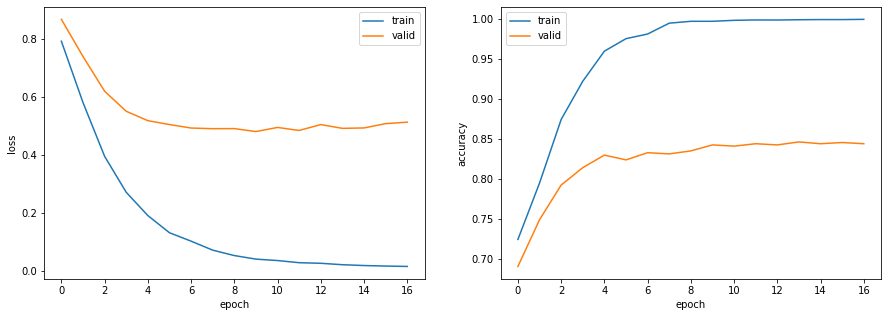

正解率（学習データ）：0.999
正解率（評価データ）：0.851


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')